In [1]:
# Jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [175]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskLassoCV, LinearRegression
import matplotlib.pyplot as plt
from logistic_with_offset import LogisticWithOffset


def gen_data(n_samples, dim_x, dim_z, kappa_x, kappa_theta, sigma_eta):
    """ Generate data from:
    Pr[y|x,t] = Sigmoid(<z[support_theta], theta> * t + <x[support_x], alpha_x>)
    t = <x[support_x], beta_x> + eta
    epsilon ~ Normal(0, sigma_epsilon)
    eta ~ Normal(0, sigma_eta)
    z = (x[subset_z], 1) for some subset of x of size dim_z - 1
    alpha_x, beta_x, theta are all equal to 1
    support_x, support_theta, subset_z drawn uniformly at random
    """
    x = np.random.uniform(-.5, .5, size=(n_samples, dim_x))
    supp_z = np.random.choice(np.arange(x.shape[1]), dim_z, replace=False)
    z = x[:, supp_z].reshape(n_samples, -1)
        
    support_x = np.random.choice(np.arange(0, dim_x), kappa_x, replace=False)
    support_theta = np.random.choice(np.arange(0, dim_z), kappa_theta, replace=False)
    alpha_x = np.random.uniform(1, 1, size=(kappa_x, 1))
    beta_x = np.random.uniform(1, 1, size=(kappa_x, 1))
    theta = np.random.uniform(1, 1, size=(kappa_theta, 1))
    t = np.dot(x[:, support_x], beta_x) + np.random.normal(0, sigma_eta, size=(n_samples, 1))
    index_y = np.dot(z[:, support_theta], theta) * t + np.dot(x[:, support_x], alpha_x)
    p_y = 1/(1+np.exp(-index_y))
    y = np.random.binomial(1, p_y)
    return x, t, z, y, support_x, support_theta, alpha_x, beta_x, theta

def direct_fit(x, t, z, y):
    n_samples = x.shape[0]
    
    model_t = LinearRegression(fit_intercept=False) #Lasso(alpha=np.sqrt(np.log(x.shape[1])/n_samples))
    model_t.fit(x, t.ravel())

    comp_x = np.concatenate((z * t, x), axis=1)
    steps = 10000
    lr = 1/np.sqrt(steps)
    l1_reg = np.sqrt(np.log(comp_x.shape[1])/(n_samples))/2.
    #model_y = LogisticWithOffset(alpha_l1=l1_reg, alpha_l2=0.,\
    #                             steps=steps, learning_rate=lr)
    model_y = LogisticRegression(penalty='l1', C=1./l1_reg)
    model_y.fit(comp_x, y.reshape(-1, 1))
    
    return model_y, model_t
    

def dml_fit(x, t, z, y):
    """ Orthogonal estimation of coefficient theta
    """
    n_samples = x.shape[0]
    comp_x = np.concatenate((z * t, x), axis=1)
    
    tr_inds, tst_inds = np.arange(n_samples//2), np.arange(n_samples//2, n_samples)
    model_y, model_t = direct_fit(x[tr_inds], t[tr_inds], z[tr_inds], y[tr_inds])
    
    # \tilde{theta}
    theta_prel = model_y.coef_.flatten()[:z.shape[1]].reshape(-1, 1)
    # \tilde{f}(u) = u'alpha_prel
    alpha_prel = model_y.coef_.flatten()[z.shape[1]:].reshape(-1, 1)
    # \tilde{h}(u) = u'beta_prel
    beta_prel = model_t.coef_.flatten().reshape(-1, 1)
    # \tilde{\pi}(u) = model_t.predict(u)
    t_test_pred = model_t.predict(x[tst_inds]).reshape(-1, 1)
    # G_prel = model_y.predict([x, u])
    y_test_pred = model_y.predict_proba(comp_x[tst_inds])[:, 1].reshape(-1, 1)
    # \hat{q}(u) = \pi(u) * B(u)'\tilde{theta} + u'\tilde{alpha}
    q_test = t_test_pred * np.dot(z[tst_inds], theta_prel) + np.dot(x[tst_inds], alpha_prel)
    # V(z) = G(index) * (1 - G(index))
    V_test = y_test_pred * (1 - y_test_pred)
    sample_weights = (1./np.clip(V_test, 0.0001, 1))/np.mean((1./np.clip(V_test, 0.0001, 1)))
    plt.figure()
    plt.hist(sample_weights)
    plt.show()
    # res = x - \hat{h}(u) = B(u)*(tau - pi(u))
    res_test = t[tst_inds] - t_test_pred
    comp_res_test = z[tst_inds] * res_test
    y_test = y[tst_inds].reshape(-1, 1)
    steps = 10000
    lr = 1/np.sqrt(steps)
    l1_reg = np.sqrt(np.log(z.shape[1])/n_samples)/2.
    model_final = LogisticWithOffset(alpha_l1=l1_reg, alpha_l2=0.,\
                                 steps=steps, learning_rate=lr, tol=1e-7)
    model_final.fit(comp_res_test, y_test, offset=q_test, sample_weights=sample_weights)
    print(model_final.coef_.flatten())
    return model_final.coef_.flatten()

2468
done
['0.0072', '-0.048', '0.028', '0.013', '0.027', '0.025', '-0.035', '-0.017', '-0.05', '-0.012', '0.024', '0.014', '0.028', '0.018', '-0.0023', '0.019', '-0.014', '-0.014', '0.035', '0.063', '0.0088', '-0.0069', '-0.073', '-0.0095', '0.012', '0.035', '0.014', '-0.032', '0.011', '-0.015', '-0.023', '0.066', '-0.0091', '0.035', '-0.011', '-0.045', '0.021', '0.024', '-0.043', '-0.077', '-0.025', '0.011', '0.011', '-0.05', '1.0', '-0.034', '0.041', '-0.041', '0.047', '-0.024']
['-0.14', '0.25', '0.57', '-0.053', '0.58', '0.22', '-0.27', '1.2', '1.1', '0.91', '-0.21', '1.4', '1.2', '-0.13', '0.04', '0.28', '0.062', '0.9', '0.11', '1.2', '1.2', '-0.071', '-0.17', '0.98', '1.2', '0.36', '1.3', '-0.15', '1.4', '0.87', '1.3', '0.12', '-0.21', '0.35', '1.6', '0.12', '-0.06', '0.73', '-0.14', '0.62', '0.94', '0.58', '-0.24', '-0.12', '0.075', '0.78', '1.1', '1.1', '0.98', '0.39']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


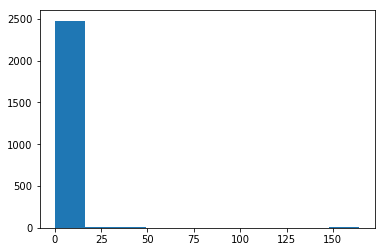

early stopping at iter:3908
[ 0.0032248  -0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.         -0.01439909 -0.          0.          0.
 -0.          0.02236701 -0.         -0.04927143 -0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.          0.
  0.          0.          0.         -0.05896434 -0.          0.         -0.
  0.         -0.          0.82317829 -0.05829277  0.         -0.         -0.
  0.        ]
2450
done
['-0.056', '-0.039', '0.015', '-0.00014', '-0.023', '-0.045', '0.068', '1.1', '0.033', '0.018', '0.026', '-0.036', '0.015', '-0.03', '-0.01', '0.031', '0.035', '-0.057', '0.037', '-0.062', '-0.012', '-0.065', '0.031', '-0.013', '0.065', '-0.012', '0.033', '-0.011', '0.035', '0.038', '0.035', '0.023', '0.024', '-0.0057', '0.0077', '-0.038', '0.03', '-0.011', '-0.039', '-0.072', '0.04', '0.0064', '-0.034', '

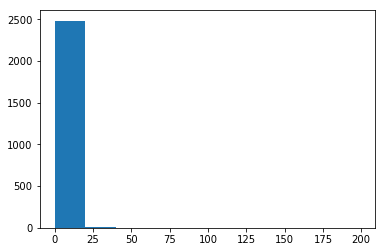

early stopping at iter:3644
[-0.         -0.          0.         -0.          0.          0.          0.
  0.85314447  0.          0.         -0.         -0.         -0.          0.
 -0.         -0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.          0.          0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.          0.
 -0.          0.         -0.         -0.         -0.          0.         -0.
  0.        ]
2496
done
['-0.0089', '-0.023', '0.0024', '-0.015', '-0.04', '0.0077', '-0.063', '1.0', '0.02', '-0.037', '0.0014', '-0.0048', '0.013', '0.038', '0.016', '0.073', '-0.04', '0.03', '-0.022', '-0.055', '-0.042', '0.011', '-0.046', '-0.015', '-0.0046', '-0.055', '-0.027', '-0.0034', '-0.032', '0.012', '0.046', '-0.043', '0.063', '-0.027', '0.023', '-0.027', '-0.01', '-0.032', '0.026', '0.0057', '0.013', '-0.031', '-0.0

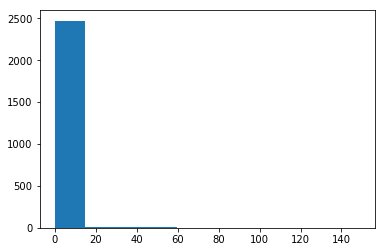

early stopping at iter:4032
[-0.          0.         -0.          0.         -0.          0.          0.
  0.89876711 -0.          0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.          0.         -0.          0.         -0.          0.
 -0.        ]
2560
done
['0.05', '-0.022', '0.038', '0.0039', '-0.0071', '-0.02', '0.012', '-0.0017', '-0.00098', '-0.028', '0.054', '0.047', '0.041', '-0.0063', '0.054', '-0.034', '0.02', '-0.00084', '-0.0048', '-0.045', '-0.006', '-0.01', '0.023', '1.0', '0.015', '0.0056', '0.0029', '-0.0059', '-0.028', '0.057', '-0.078', '0.019', '-0.033', '0.024', '0.061', '0.021', '-0.02', '-0.0028', '-0.016', '0.0058', '-0.0019', '-0.032', 

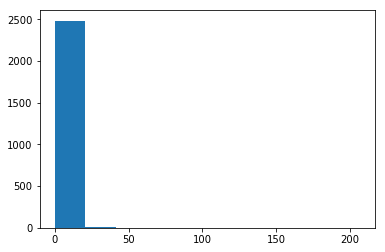

early stopping at iter:4163
[-0.         -0.05142189  0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.         -0.
  0.0397309   0.          0.         -0.         -0.          0.          0.
 -0.          0.          0.73975492 -0.         -0.         -0.          0.
  0.          0.          0.          0.07121287  0.          0.0058636   0.
 -0.          0.         -0.          0.02423496 -0.04816898 -0.          0.
 -0.0287932   0.          0.          0.          0.05027887 -0.01507066
  0.01785655 -0.04004676]
2633
done
['0.031', '0.023', '0.028', '0.026', '0.0092', '-0.033', '0.012', '0.028', '-0.02', '-0.025', '0.027', '-0.017', '-0.025', '0.02', '0.031', '0.021', '0.0073', '0.011', '0.033', '0.012', '-0.035', '-0.036', '-0.0013', '0.016', '0.045', '0.00069', '0.00066', '0.028', '0.013', '-0.02', '1.1', '0.014', '0.027', '-0.0098', '0.0011', '-0.023', '0.0037', '0.035', '-0.043', '0.016', '-0.016', '-0.0048', '0

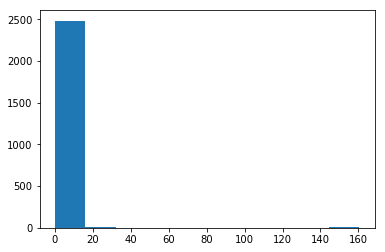

early stopping at iter:1797
[ 0.03794186  0.          0.00808191  0.          0.         -0.          0.
 -0.01219599  0.          0.          0.          0.          0.         -0.
  0.         -0.01611973 -0.01883343  0.          0.          0.         -0.
  0.         -0.          0.          0.         -0.          0.          0.
 -0.00649347 -0.          0.70886689  0.00261599  0.04039655  0.         -0.
 -0.00426894 -0.          0.         -0.         -0.00551532 -0.         -0.
  0.01730738  0.          0.          0.         -0.          0.         -0.
  0.        ]


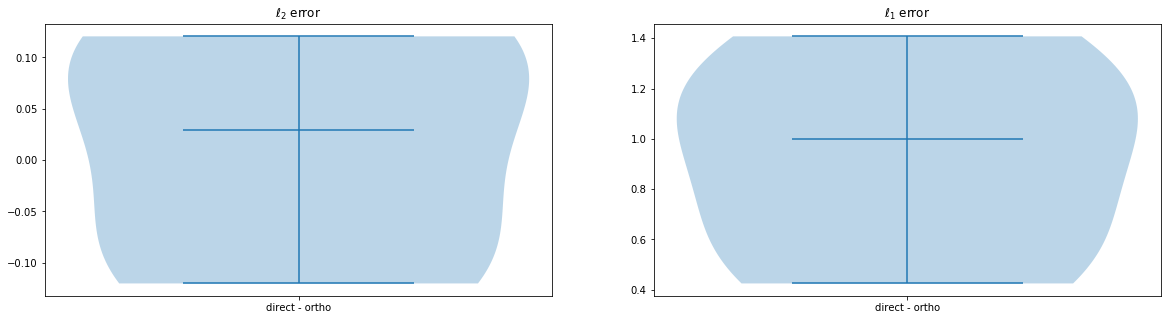

In [176]:
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskLassoCV, LinearRegression
import matplotlib.pyplot as plt


def main():
    n_samples = 5000 # samples used for estimation
    dim_x = 50 # dimension of controls x
    dim_z = 50 # dimension of variables used for heterogeneity (subset of x)
    kappa_x = 25 # support size of control function
    kappa_theta = 1 # support size of target parameter
    sigma_eta = 5 # variance of error in secondary moment equation
    lambda_coef = 1 # coeficient in front of the asymptotic rate for regularization lambda

    l2_direct = []
    l2_ortho = []
    l2_cross_ortho = []
    l1_direct = []
    l1_ortho = []
    l1_cross_ortho = []
    for _ in range(5):
        # Generate data
        x, t, z, y, support_x, support_theta, alpha_x, beta_x, theta =\
                gen_data(n_samples, dim_x, dim_z, kappa_x, kappa_theta, sigma_eta)
        print(np.sum(y>0))
        true_coef = np.zeros((dim_z, 1))
        true_coef[support_theta] = theta
        #print(true_coef)
        
        t_true_coef = np.zeros((dim_x, 1))
        t_true_coef[support_x] = beta_x
        #print(t_true_coef)

        # Direct lasso for all coefficients
        model_y, model_t= direct_fit(x, t, z, y)
        print("done")
        l1_direct.append(np.linalg.norm(model_y.coef_.flatten()[:z.shape[1]] - true_coef.flatten(), ord=1))
        l2_direct.append(np.linalg.norm(model_y.coef_.flatten()[:z.shape[1]].flatten() - true_coef.flatten(), ord=2))
        
        print(["{:.2}".format(c) for c in model_y.coef_.flatten()[:z.shape[1]]])
        print(["{:.2}".format(c) for c in model_t.coef_.flatten()])

        # Orthogonal lasso estimation
        ortho_coef = dml_fit(x, t, z, y)
        l1_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=1))
        l2_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=2))


    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.violinplot([np.array(l2_direct) - np.array(l2_ortho)], showmedians=True)
    plt.xticks([1], ['direct - ortho'])
    plt.title('$\ell_2$ error')
    plt.subplot(1,2,2)
    plt.violinplot([np.array(l1_direct) - np.array(l1_ortho)], showmedians=True)
    plt.xticks([1], ['direct - ortho'])
    plt.title('$\ell_1$ error')
    plt.show()
    
main()